# Mirai-haittaohjelman tuottaman verkkoliikenteen tunnistaminen

Data setti: Aposemat IoT-23 - setit 44 ja 49: Mirai<br>
Valikoitunut menetelmä: MLM<br>

**Mirai-haittaohjelma**

Mirai on botnet-verkostoja luova haittaohjelma. Saastutettuaan yksittäisen laitteen, ohjelma ottaa yhteyden komentopalvelimelle (C&C) ja lataa seuraavan vaiheen ohjelmakoodin laitteelle. Tämän jälkeen haittaohjelma ryhtyy skannaamaan verkkoa löytääkseen muita haavoittuvia laitteita. Löydettyään sopivan haavoittuvan laitteen, haittaohjelma yrittää automaattisesti levitä edelleen löydetyille laitteille. Samanaikaisesti haittaohjelma kuuntelee komentopalvelimelta tulevia käskyjä, joiden avulla saastuneita laitteita voidaan käskyttää esimerkiksi osallistumaan hajautettuihin palvelunestohyökkäyksiin(DDoS).

Edellämainittu käyttäytyminen näkyy käytetyssä raakadatassa siten, että haavoittuvien laitteiden etsinnässä syntyvää porttiskannaus-liikennettä oli raakadatasta ylivoimaisesti suurin osa. Datan esikäsittelyssä karsin porttiskannausdataa siten, että sitä oli varsinaisessa käsitellyssä datassa suurinpiirtein sama määrä kuin normaalia verkkoliikennettä.

**Projektin rakenteesta**

Suurin osa käsittelyvaiheista on määritelty funktioina jotka löytyvät tämän notebookin alusta.<br>
MLM:n toteutuksessa on käytetty kurssin luennolla 10 esiteltyä esimerkkiä.

Varsinainen ylätason ohjelmalogiikka alkaa notebookin puolivälistä.

In [84]:
# Käytettyjen kirjastojen lataus
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split

**Datan lukeminen esiprosessoidusta tiedostosta.**

Datasta muodostetaan kaksi erillistä pandas dataframea. <br>df_X frameen tulee data ilman taustatotuutta. <br> df_ids frameen otetaan taustatotuus ja rivikohtainen indeksi, jolla luokka voidaan yhdistää takaisin varsinaisiin datapisteisiin.

Tämä tehdään, jotta koko datamassa saadaan ajettua läpi normalisoinnista, standardoinnista ja dimensioiden vähentämisestä kerralla. Näin pyritään takaamaan että esikäsittely tehdään varmasti sammalla tavalla kaikille datapisteille.

Jako opetusdataan, sen referenssipisteisiin ja testidataan tehdään df_ids dataframeä käyttäen ja varsinainen data jaetaan näihin ryhmiin pisteiden rivinumeroa päädatassa kuvaavien id-tietueiden avulla.

In [85]:
# import data
df_X = pd.read_csv('./data/preprocessed/bigframeMirai2.csv')
# Poistetaan vanhat id:t ja lisätään juokseva id
df_X.drop(columns=['id'])
df_X['id'] = range(0,len(df_X))
df_ids = df_X[['label','id']]
print(df_X.shape)

(8747, 20)


**Funktioiden määrittelyt**

In [86]:
# Lähtödatan luokkien jako opetus dataan (referenssipisteet df_ref ja muu opetusdata df_train) 
def class_preparation(df_C, ref_pts):
  df_fulltrain, df_test = train_test_split(df_C)
  
  # df_train, df_ref = train_test_split(df_fulltrain)

  ids = np.arange(0, df_fulltrain.shape[0])
  
  pts = min(ref_pts,20)

  np.random.shuffle(ids)
  df_ref = df_fulltrain.iloc[ids[0:pts]]
  df_train = df_fulltrain.iloc[ids[pts::]]
  
  return df_ref, df_train, df_test

In [87]:
# Luokan opetusdatan jako referenssipisteisiin, muuhun opetusdataan ja testidataan:
def full_preparation(df_C):
  dfs = []
  i = 0
  while i < 6:
    labeled = df_C[df_C['label'] == i]

    dfs.append(labeled)
    i = i + 1

  refs = []
  trains = []
  tests = []
  i = 0
  for frame in dfs:
    if len(frame) > 1: # yhdessä taustatotuus luokassa on vain yksi datapiste. Tästä syystä ehdollinen käsittely
      ref, train, test = class_preparation(frame, (len(frame) // 3))
      refs.append(ref)
      trains.append(train)
      tests.append(test)
      print(' Luokka: ' + str(i) + ' koko: ' + str(len(frame)) + ' referenssidata: '+ str(len(ref)) + ' Opetusdata: '+ str(len(train))+ ' Testidata: '+ str(len(test)))
    else:
      tests.append(frame)
      print(' Luokka: ' + str(i) + ' koko: ' + str(len(frame)) + ' referenssidata: 0 Opetusdata: 0 Testidata: 1')
    i += 1

  df_ref = pd.concat(refs)
  df_train = pd.concat(trains)
  df_test = pd.concat(tests)
  
  return (df_ref, df_train, df_test)

In [88]:
# Datan jako opetus ja testidataan
def split_to_train(X):
  X_train, X_test= train_test_split(X, test_size=0.4, random_state=42, shuffle=True)

  return (X_train, X_test)

In [89]:
# MLM-mallin koulutus
def mlm_fit(X, Y, R, T):
  D_x = sp.spatial.distance.cdist(X, R)
  Dlt_y = sp.spatial.distance.cdist(Y, T)
  B = np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(D_x),D_x)),np.transpose(D_x)),Dlt_y)
  return B

In [90]:
# MLM luokittelu: etäisyyden optimointi
def mlm_test(X_1, R, T, B):
  from scipy.optimize import least_squares

  def J_fun(y, delta_yT, T):
    return np.sum((np.multiply(np.transpose(y-T),(y-T))-delta_yT**2)**2)

  y = np.zeros(X_1.shape[0])
  a = np.zeros(X_1.shape[0])

  for i in range(X_1.shape[0]):
    d_xR = sp.spatial.distance.cdist(X_1[i,:].reshape(1,X_1.shape[1]),R)
    delta_yT = np.matmul(d_xR,B)
    y_hat = least_squares(J_fun,0,method='trf', args=(delta_yT,T))

    y[i] = y_hat.x[:]
    a[i] = np.sqrt(np.sum(delta_yT**2))
  
  return y, a

In [91]:
# MLM luokittelu: äänestys
def mlm_maj_vote(X_test, R, T, B, k, metriX):
  y = np.zeros(X_test.shape[0])
  a = np.zeros(X_test.shape[0])

  d_xR = sp.spatial.distance.cdist(X_test, R, metric=metriX)
  delta_yT = np.matmul(d_xR, B)

  from scipy.stats import mode
  k_shortest_id = np.argsort(delta_yT)[:,k]
  y = mode(T[k_shortest_id,:],axis=1,keepdims=True)[0][:,0]

  return y

In [92]:
# Datan standardointi ja normalisointi
def normalize(X):
  minimum = X.min(axis=0, keepdims=True)
  maximum = X.max(axis=0, keepdims=True)
  keskihajonta = X.std(axis=0, keepdims=True)

  range = maximum - minimum
  
  X_fRange = (X - minimum) / range
  #X_ustd = X / keskihajonta

  return X_fRange


In [93]:
# Pääkomponenttianalyysi
# (Käytettiin esitellyssä versiossa ja on sen takia jätetty tähän)
def pca(X):
  print(X.shape[1])
  pca = PCA(n_components=X.shape[1])
  X_pca = pca.fit_transform(X)
  
  #print(pca.singular_values_)
  return X_pca

In [94]:
# Kernel Pääkomponenttianalyysi
def kernel_pca(X):
  pca = KernelPCA(n_components=17, kernel='sigmoid',gamma=0.01)
  X_pca = pca.fit_transform(X)
  
  #print(pca.eigenvalues_)
  return X_pca

In [95]:
# mallin tunnuslukujen laskeminen
def perfomance_kpis(Y_result, Y_true, names):
  #Y_res = np.floor(Y_result)
  
  from sklearn.metrics import confusion_matrix, classification_report
  report = classification_report(Y_result, Y_true, zero_division=True, target_names=names)
  auc = confusion_matrix(Y_true, Y_result)
  return report, auc


# Varsinainen toteutus lähtee tästä

In [96]:
#suoritetaan datajoukkojen valinta
ref_id, train_id, test_id = full_preparation(df_ids)
cols = df_X.columns.to_list()

# Muutetaan dataframe numpy-matriiseiksi X ja Y.
# X:stä jätetään pois dataframen ensimmäinen sarake ('id') ja viimeinen sarake ('label'). 
# Y pitää sisällään vain taustatotuudel ('label')
X = df_X[cols[1:len(cols)-1]].to_numpy()
Y = df_ids['label'].to_numpy()

X_norm = normalize(X)
X_pca = kernel_pca(X_norm)

X_train = X_pca[train_id['id']]
Y_train = Y[train_id['id']].reshape(X_train.shape[0],1)

X_test = X_pca[test_id['id']]
Y_test = Y[test_id['id']].reshape(X_test.shape[0],1)

R = X_pca[ref_id['id']]
T = Y[ref_id['id']].reshape(R.shape[0],1)

B = mlm_fit(X_train, Y_train, R, T)

Y_fitted, a = mlm_test(X_test, R, T, B)
Y_voted = mlm_maj_vote(X_test, R, T, B, k=1, metriX='euclidean')

 Luokka: 0 koko: 3876 referenssidata: 20 Opetusdata: 2887 Testidata: 969
 Luokka: 1 koko: 1936 referenssidata: 20 Opetusdata: 1432 Testidata: 484
 Luokka: 2 koko: 12 referenssidata: 4 Opetusdata: 5 Testidata: 3
 Luokka: 3 koko: 1 referenssidata: 0 Opetusdata: 0 Testidata: 1
 Luokka: 4 koko: 14 referenssidata: 4 Opetusdata: 6 Testidata: 4
 Luokka: 5 koko: 2908 referenssidata: 20 Opetusdata: 2161 Testidata: 727


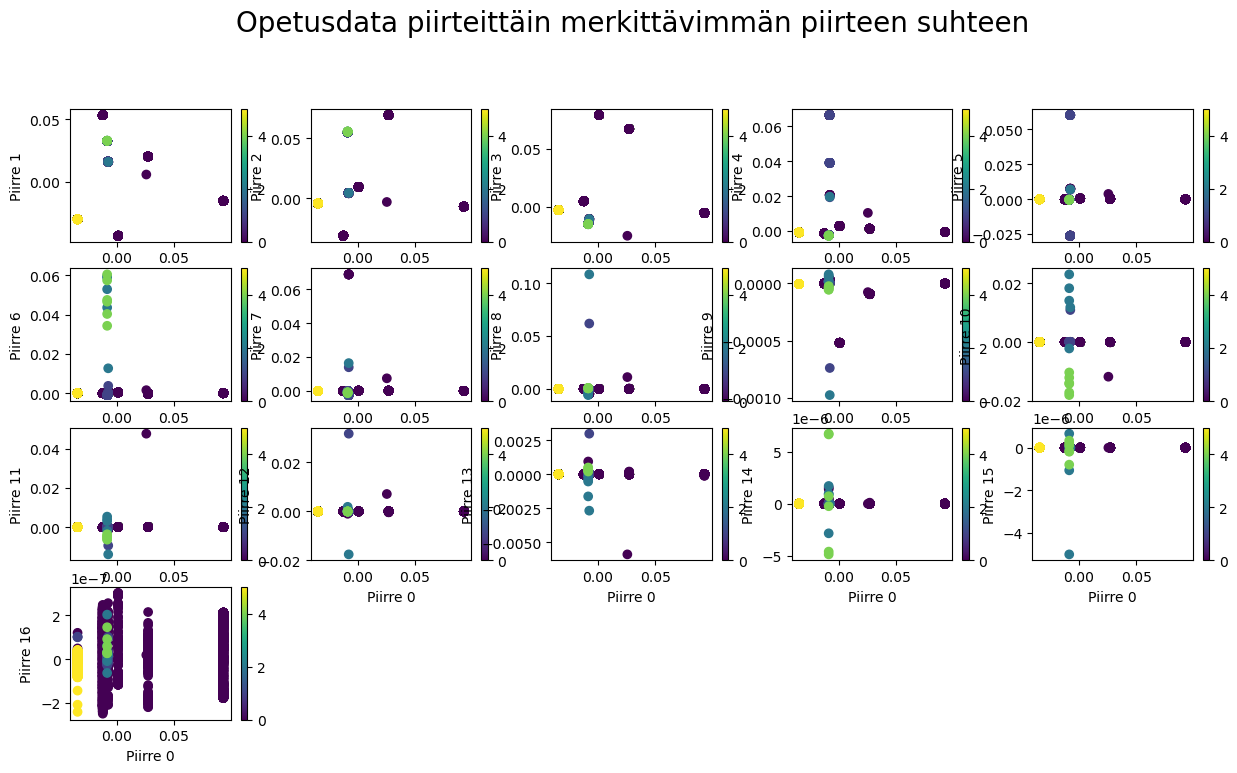

In [97]:
# Opetusdata piirrettynä piirteittäin merkittävimmän piirteen suhteen
dims = X_train.shape[1]
i = 1
fig = plt.figure(figsize=(15,10))
fig.suptitle("Opetusdata piirteittäin merkittävimmän piirteen suhteen",fontsize=20)
while i < dims:
  plt.subplot(5,5,i)
  plt.scatter(X_train[:,0],X_train[:,i],c=Y_train)
  plt.xlabel("Piirre 0")
  plt.ylabel("Piirre " + str(i))
  plt.colorbar()
  i += 1

plt.savefig('image.png')

Luokitteluraportti, Majority voting
                  precision    recall  f1-score   support

          Benign       0.49      0.74      0.59       642
             C&C       0.28      0.44      0.34       307
C&C-FileDownload       0.00      1.00      0.00         0
            DDoS       0.00      1.00      0.00         0
    FileDownload       0.00      0.00      0.00        44
        PortScan       0.69      0.42      0.52      1195

        accuracy                           0.51      2188
       macro avg       0.24      0.60      0.24      2188
    weighted avg       0.56      0.51      0.50      2188



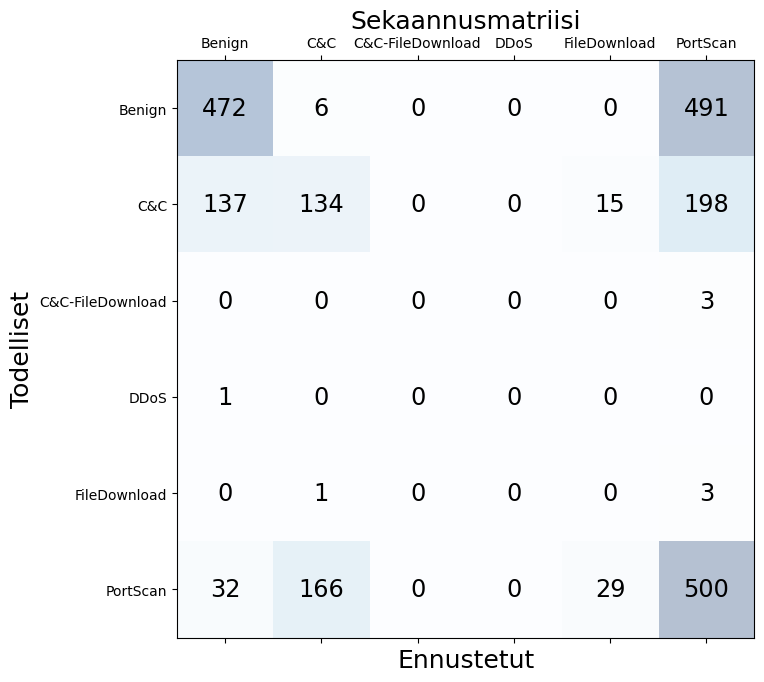

In [101]:
# Raporttien tulostaminen
names = ['Benign','C&C','C&C-FileDownload','DDoS','FileDownload','PortScan']
report_voted, conf_voted = perfomance_kpis(Y_voted, Y_test, names)
#report_fitted = perfomance_kpis(Y_fitted, Y_test)
print('Luokitteluraportti, Majority voting')
print(report_voted)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_voted, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_voted.shape[0]):
    for j in range(conf_voted.shape[1]):
        ax.text(x=j, y=i,s=conf_voted[i, j], va='center', ha='center', size='xx-large')
 
plt.xticks(range(0,6),names)
plt.yticks(range(0,6),names)
plt.xlabel('Ennustetut', fontsize=18)
plt.ylabel('Todelliset', fontsize=18)
plt.title('Sekaannusmatriisi', fontsize=18)
plt.show()

#print('Luokitteluraportti, etäisyyden minimointi')
#print(report_fitted)

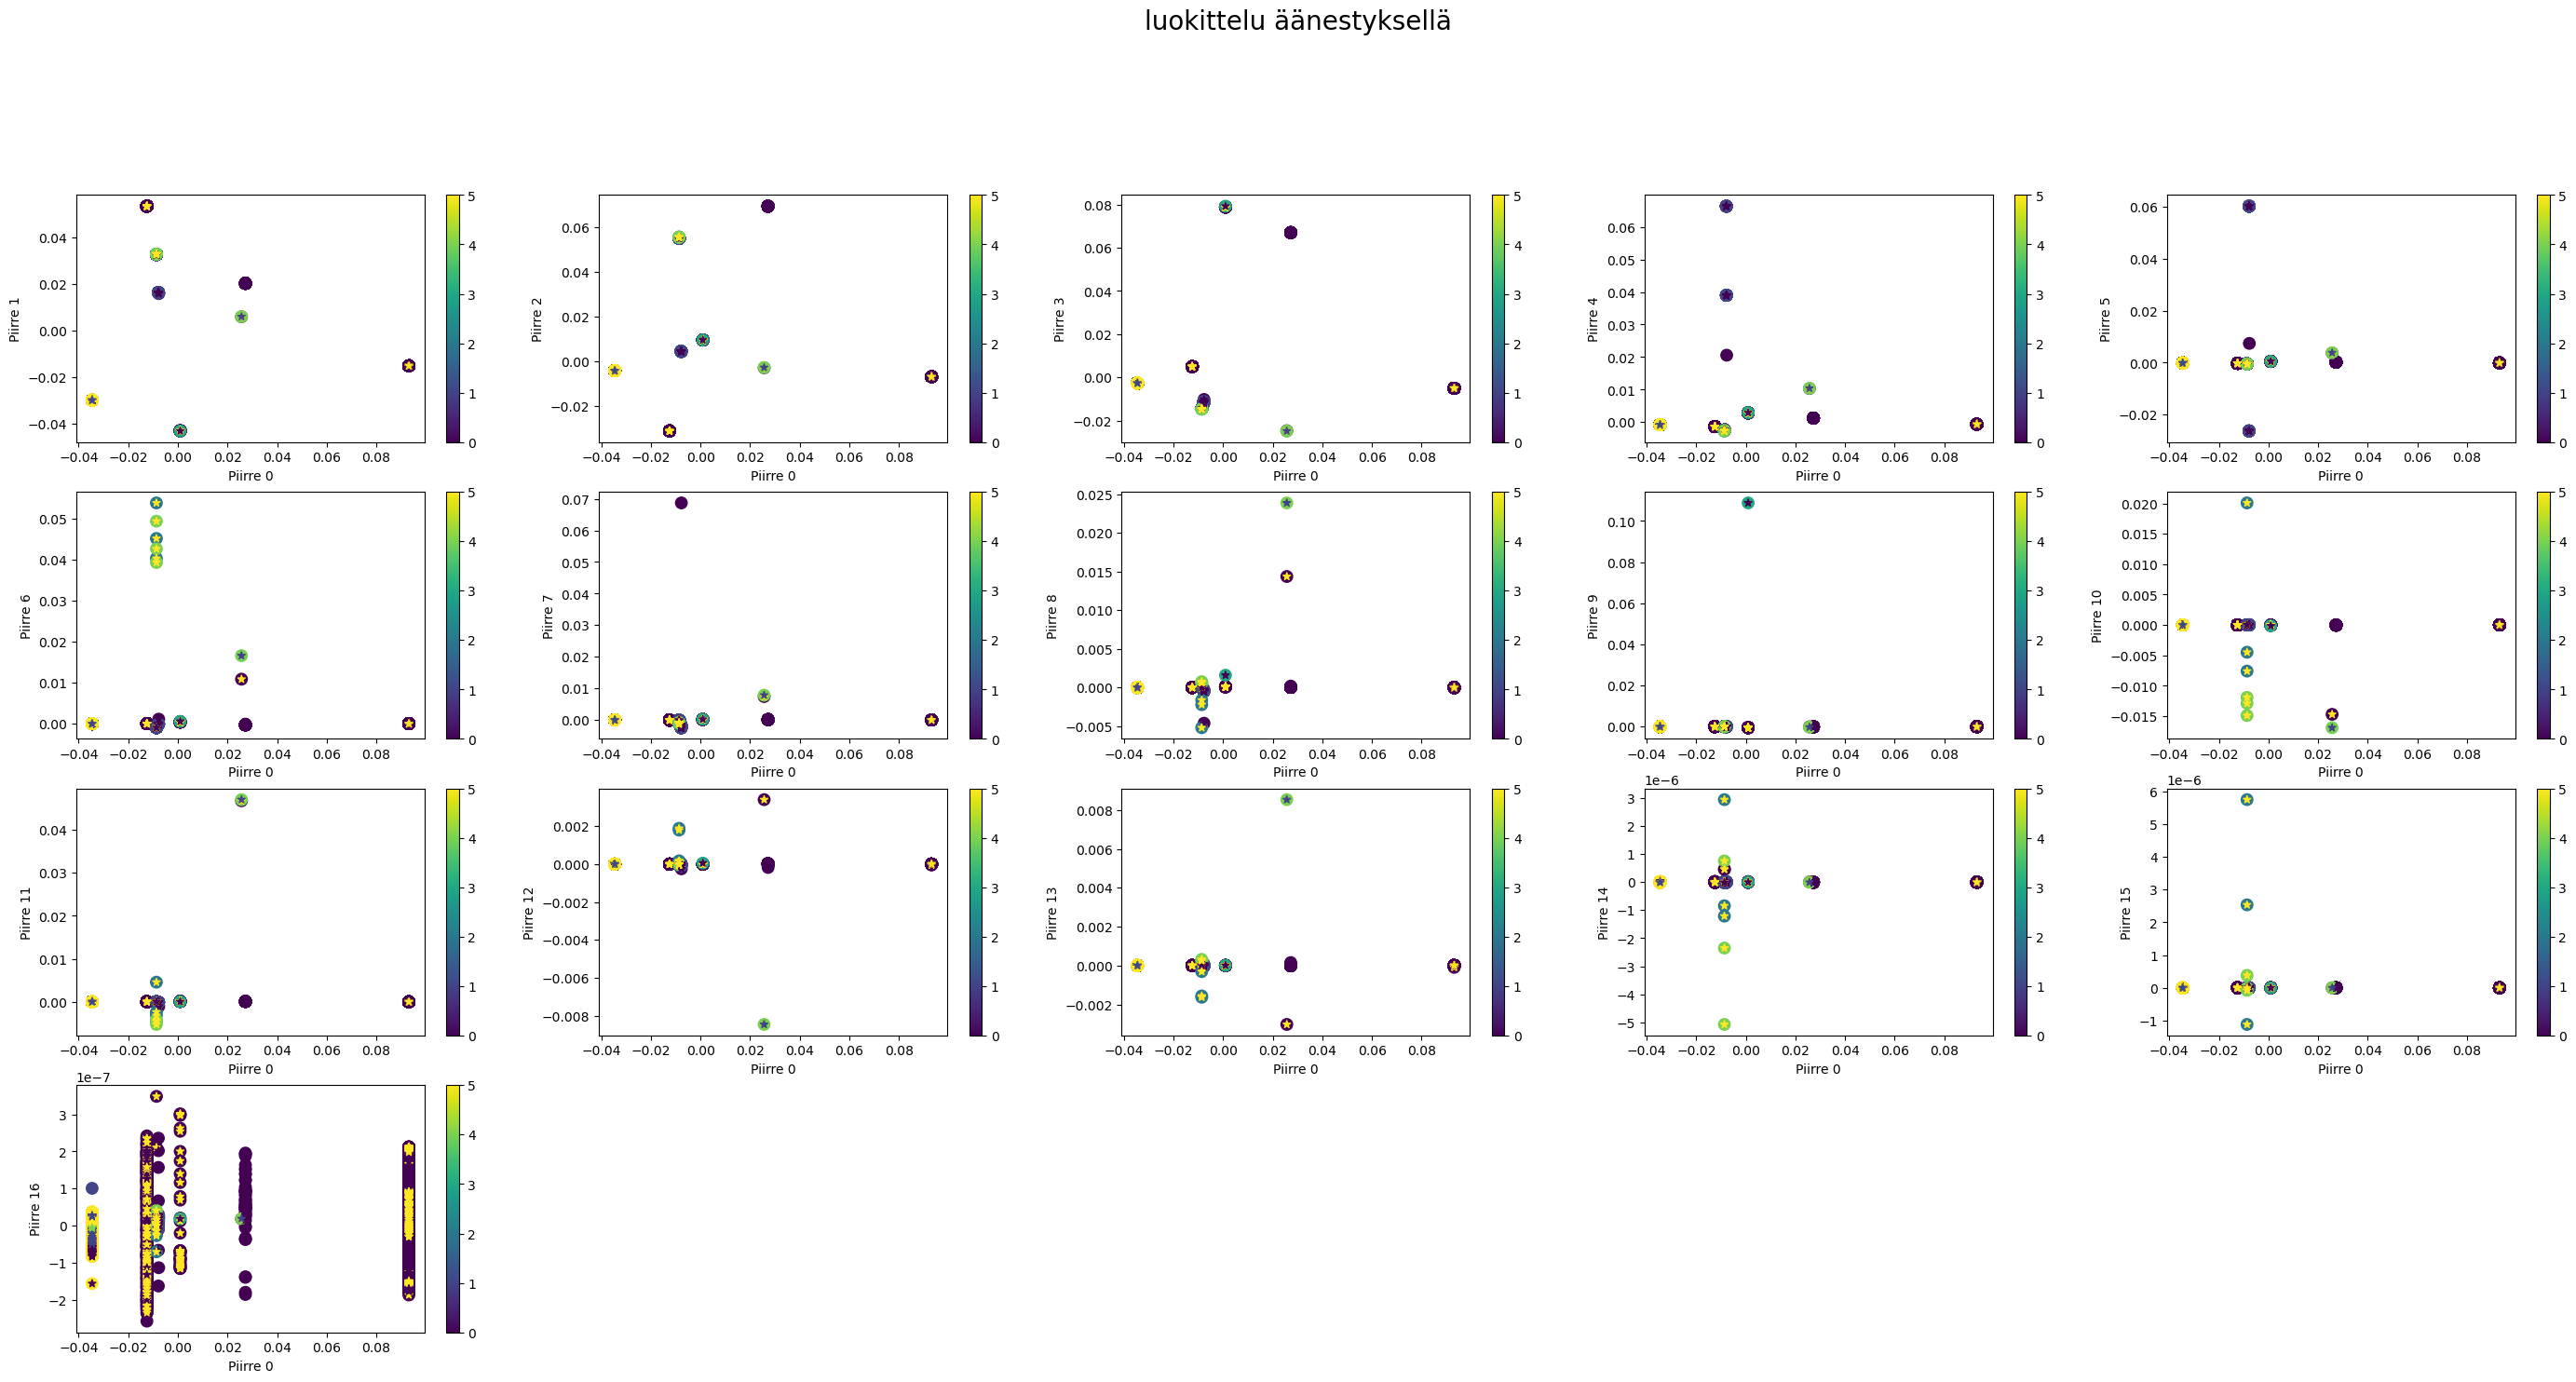

In [100]:
# Tulosten visualisointi: Ympyrä: oikea taustatotuus. Tähti: mallin tuottama luokittelutulos
dims = X_train.shape[1]
i = 1
fig = plt.figure(figsize=(35,20))
plt.suptitle('luokittelu äänestyksellä', fontsize=20)
while i < dims:
  plt.subplot(5,5,i)
  plt.scatter(X_test[:,0],X_test[:,i],marker='o',c=Y_test,sizes=[80])
  plt.scatter(X_test[:,0],X_test[:,i],marker='*',c=Y_voted)
  plt.colorbar()
  plt.xlabel("Piirre 0")
  plt.ylabel("Piirre " + str(i))
  i += 1

plt.savefig('image2.png')

# i = 1
# fig = plt.figure(figsize=(15,10))
# plt.suptitle('luokittelu optimoimalla etäisyyttä', fontsize=20,sizes=[80])
# while i < dims:
#   plt.subplot(2,2,i)
#   plt.scatter(X_test[:,0],X_test[:,1],marker='o',c=Y_test)
#   plt.colorbar()
#   plt.scatter(X_test[:,0],X_test[:,1],marker='*',c=Y_fitted)
#   plt.colorbar()
#   plt.xlabel("Piirre 0")
#   plt.ylabel("Piirre " + str(i))
#   i += 1
# plt.savefig('image3.png')

# Huomioita ja johtopäätöksiä

Dataan tutustumiseen olisi tullut käyttää enenmmän aikaa. Suuri osa datan piirteistä on binäärisiä (arvo 0 tai 1) ja kuvaa datapisteen kuvaaman tapahtuman kuulumista tiettyyn verkkoliikennetyyppiin. Tästä syystä eri luokkiin kuuluvat pisteet ovat usein päällekkäisiä.

Kunnollisella dataan tutustumisella olisin voinut aikaisemmin tunnistaa etteivät lineaariset menetelmät (esimerkiksi normaali PCA) toimi tämän datan kanssa. Tässä viimeisimmässä versiossa PCA on korvattu kernel-PCA:lla, joskin tulokset eivät ole juuri sen parempia.

Alkuperäisessä toteutuksessa ei myöskään ollut otettu huomioon kaikkien luokkien löytymistä kaikista dataryhmistä (referenssi, opetus, testi). Tässä versiossa datan jakoa on parannettu, mutta sovelluksen muiden ongelmien takia merkittävää parannusta ei saavuteta.

MLM:n valinta käytetyksi menetelmäksi oli liian kunnianhimoinen suhteessa omaan taitotasooni. Valmiiden menetelmäkirjastojen käytämisen sijaan käytetty MLM-mallikoodi olisi vaatinut parempaa perehtymistä sen matemaattiseen taustaan. Esimerkiksi en saanut minimointiongelman ratkaisuun perustuva luokittelua toimimaan, enkä onnistunut keksimään olisiko asialle ollut jotain tehtävissä, vai johtuiko toimimattomuus vain huonosti erottuvasta datasta. Tähän luokittelutapaan liittyvät tulokset on jätetty viimeisestä ajosta pois, sillä ne olivat niin ilmiselvästi väärät, koodiosuudet kommentoinuina.

Aikaa paloi myös paljon käytetyn kielen perusteiden kertaamisen ja ymmärtämisen vaatimaan opetteluun ja kertaaamiseen.